#**AUTOMATE DETECTION OF DIFFERENT SENTIMENTS FROM PARAGRAPHS AND PREDICT OVERALL SENTIMENTS**

#**USING RNN + LSTM**

#**IMPORTING THE REQUIRED DEPENDENCIES**

In [1]:
# IMPORTING THE DEPENDENCIES
import tensorflow_datasets as tfds
import tensorflow as tf

##**LOADING THE DATASET**

###**THE IMDB MOVIE DATASTE IS A PREPROCESSED DATASET**

In [2]:
# LOADING THE DATASET FROM TENSORFLOW DATASETS
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/incomplete.LJC5JC_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/incomplete.LJC5JC_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/incomplete.LJC5JC_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
# RETRIEVE A BATCH OF TRAINING EXAMPLES AND THEIR CORRESPONDING LABESL FROM THE TRAINING DATASET
train_examples_batch, train_labels_batch = next(iter(train_dataset))
print(train_examples_batch)
print(train_labels_batch)

tf.Tensor(
[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975], shape=(163,), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


#**TEXT ENCODING**


##**The Dataset info includes the encoder (a `tfds.features.text.SubwordTextEncoder`).**


##**This Text encoder will reversibly encode any string, falling back to byte-encoding if necessary.**

In [4]:
# RETRIEVE THE ENCODER ASSOCIATED WITH THE 'TEXT' FEATURE FROM THE DATASET'S METADATA
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
# Define a sample string to be encoded
sample_string = 'Hello TensorFlow.'

# Encode the sample string into its numerical representation using the encoder
encoded_string = encoder.encode(sample_string)

# Print the encoded string
print('Encoded string is {}'.format(encoded_string))

# Decode the encoded string back to its original form using the encoder
original_string = encoder.decode(encoded_string)

# Print the original string after decoding
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [6]:
# Assert that the decoded string is the same as the original string
assert original_string == sample_string

# Iterate over each index in the encoded string
for index in encoded_string:
  # Print the encoded index and its corresponding decoded character
  print('{} ----> {}'.format(index, encoder.decode([index])))


4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


##**Create batches of training data for your model. The reviews are all different lengths, so use `padded_batch` to zero pad the sequences while batching.**

In [7]:
# Define the buffer size for shuffling and the batch size for batching
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Shuffle the training dataset with the defined buffer size to ensure randomness
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# Batch the training dataset into padded batches of the defined batch size
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

# Batch the test dataset into padded batches of the defined batch size
test_dataset = test_dataset.padded_batch(BATCH_SIZE)


##**Build Model with an LSTM layer**

###Creating a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

###This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense layer`.

###A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

###The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.
###Keras sequential model here since all the layers in the model only have single input and produce single output.

In [8]:
# Define a sequential model
model = tf.keras.Sequential([

    # Add an embedding layer with the vocabulary size of the encoder and an embedding dimension of 64
    tf.keras.layers.Embedding(encoder.vocab_size, 64),

    # Add a bidirectional LSTM layer with 64 units
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Add a dense layer with 64 units and ReLU activation function
    tf.keras.layers.Dense(64, activation='relu'),

    # Add a final dense layer with 1 unit (output layer)
    tf.keras.layers.Dense(1)
])

# Printing the model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598209 (2.28 MB)
Trainable params: 598209 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##**Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), we'll use the `binary_crossentropy` loss function. It is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.**

#**COMPILING THE MODEL**

In [9]:
# Compile the model with specified loss function, optimizer, and metrics
model.compile(
    # Use binary crossentropy loss function, appropriate for binary classification tasks
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    # Use Adam optimizer with a learning rate of 1e-4
    optimizer = tf.keras.optimizers.Adam(1e-4),
    # Evaluate the model performance using accuracy metric
    metrics = ['accuracy']
)

#**MODEL TRAINING**

##**Train the model for 10 `epochs`. This is 10 iterations over all samples in the `train_dataset` tensors.**

In [10]:
# Train the model using the training dataset and validate using the test dataset
history = model.fit(
    train_dataset,          # The dataset to use for training the model
    epochs = 10,            # Number of epochs to train the model
    validation_data = test_dataset,    # The dataset to use for validation
    validation_steps = 30   # Number of steps to validate the model on the validation dataset
)

Epoch 1/10
391/391 [==============================] - 1130s 3s/step - loss: 0.6403 - accuracy: 0.5598 - val_loss: 0.4503 - val_accuracy: 0.8073
Epoch 2/10
391/391 [==============================] - 1004s 3s/step - loss: 0.3381 - accuracy: 0.8602 - val_loss: 0.3421 - val_accuracy: 0.8589
Epoch 3/10
391/391 [==============================] - 951s 2s/step - loss: 0.2461 - accuracy: 0.9067 - val_loss: 0.3513 - val_accuracy: 0.8495
Epoch 4/10
391/391 [==============================] - 966s 2s/step - loss: 0.2124 - accuracy: 0.9202 - val_loss: 0.3299 - val_accuracy: 0.8646
Epoch 5/10
391/391 [==============================] - 970s 2s/step - loss: 0.1818 - accuracy: 0.9343 - val_loss: 0.3702 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 988s 3s/step - loss: 0.1562 - accuracy: 0.9446 - val_loss: 0.3644 - val_accuracy: 0.8698
Epoch 7/10
391/391 [==============================] - 997s 3s/step - loss: 0.1389 - accuracy: 0.9520 - val_loss: 0.3877 - val_accuracy: 0.86

#**EVALUATING THE MODEL**

##**Test For Accuracy**

In [11]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)

# Print the test loss
print('Test Loss: {}'.format(test_loss))
# Print the test accuracy
print('Test Accuracy: {}'.format(test_acc))


391/391 [==============================] - 233s 597ms/step - loss: 0.4695 - accuracy: 0.8498
Test Loss: 0.4694693088531494
Test Accuracy: 0.8497999906539917


#**Prediction Functions**

In [ ]:
# Define a function to pad a vector with zeros up to a specified size
def pad_to_size(vec, size):

  # Create a list of zeros with length equal to the difference between the desired size and the current length of the vector
  zeros = [0] * (size - len(vec))

  # Extend the original vector by appending the zeros to it
  vec.extend(zeros)

  # Return the padded vector
  return vec


def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [13]:
# Define a function to predict sentiment based on a sample text input
def sample_predict(sample_pred_text, pad):

  # Encode the sample prediction text using the encoder
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  # Pad the encoded text to a fixed size if specified
  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)

  # Convert the encoded text to float32 data type
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)

  # Make predictions using the trained model
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  print("Prediction Score: ", predictions)

  # Determine the sentiment based on the prediction score
  output = ""
  if predictions[0][0] >= 0.5:
    output = "POSITIVE"
  elif predictions[0][0] <= -1:
    output = "NEGATIVE"
  else:
    output = "NEUTRAL"

  # Return the predicted sentiment
  return output


#**Prediction with Sample Sentiments**

In [14]:
# Define the sample text for sentiment prediction
sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad = False)

# Print the predicted sentiment
print(predictions)

1/1 [==============================] - 1s 1s/step
Prediction Score:  [[-2.1463177]]
NEGATIVE


In [15]:
# Define the sample text for sentiment prediction
sample_pred_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad=False)

# Print the predicted sentiment
print(predictions)

1/1 [==============================] - 1s 864ms/step
Prediction Score:  [[0.14137083]]
NEUTRAL


In [16]:
# Define the sample text for sentiment prediction
sample_pred_text = ('This movie is awesome. The acting was incredible. Highly recommend')

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad=False)

# Print the predicted sentiment
print(predictions)

1/1 [==============================] - 0s 23ms/step
Prediction Score:  [[0.73364747]]
POSITIVE


In [17]:
# Define the sample text for sentiment prediction
sample_pred_text = ('This movie was so so. The acting was mediocre. Kind of recommend')

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad=False)

# Print the predicted sentiment
print(predictions)

1/1 [==============================] - 0s 37ms/step
Prediction Score:  [[0.16477194]]
NEUTRAL


In [18]:
# AVENGERS: ENDGAME 5 STAR COMMENT

# Define the sample text for sentiment prediction
sample_pred_text = ("""
I loved the movie a lot as I am great fan of marvel! Avengers: Endgame, which marks the end of the Infinity Saga, is spellbounding
and surely an enthralling experience. The last film of the 'Avengers' franchise is remarkable and doesn't disappoint. Watching all our favourite superheroes
in one film is just surpassing. Marvel has been working on this grand culmination ever since they released 'Iron Man'. I'm damn sure that all of their hard
work and ambition has paid off. The directors, Anthony and Joe Russo, have made sure that it delivers an unforgettable experience. Christopher Markus and
Stephen McFeely have come up with a screenplay full of epic and unpredictable moments. The film has a great balance of humour, emotions and action.
The biggest strength of the film is the emotions. This is the most emotional superhero film I have ever seen. It's just perfect. The action sequences
were jaw-dropping. The climatic battle left me amazed. It's just filled with memorable moments and cannot be described with words. The visuals are gorgeous
and have a great impact on the film. The humour doesn't look exaggerated and manages to entertain throughout the film. The plot twists were very impressive
and suspenseful. The film features many cameos of characters from the previous MCU films, which just gives a double dose of excitement. The background score
gives me goosebumps, though I've listened to it several times. It was really clever to make changes to the characterization of the Hulk. I enjoyed that a lot.
But the show-stealer is Robert Downey Jr, who plays the role of Tony Stark/Iron Man. The man who started it all proves yet again that there's no one else who
can perfect his role. Do not miss his powerful moments in the final battle.""")

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad=False)

# Print the predicted sentiment
print(predictions)

1/1 [==============================] - 0s 61ms/step
Prediction Score:  [[5.3453493]]
POSITIVE


In [19]:
# AVENGERS: ENDGAME 3 STAR COMMENT

# Define the sample text for sentiment prediction
sample_pred_text = ("""
Overrated Sequel, But Still Good, But Violent! Beloved characters die, a character gets their head cut off, someone falls off a cliff,
stabbings, punching, shooting, and more. The characters swear a bit. Even Captain America does! Role models include, Captain America, Iron Man, Hulk, AntMan,
Black Widow, Hawkeye. Thor not so much because he SPOILER ALERT: got fat and played Fortnite the entire 5 year period. He was funny, but you may not want your
kid wanting to say 'I want to be like the God of Thunder and play fortnite all day'. Characters did kiss. Thor drank a lot of beer. Captain America proved
himself of something but not saying what. With reviewing the movie, the first half hour was good, then the next half hour was slow. The second half hour was
pretty good, but the last hour was epic. From just starting out with Iron Man, Cap, Thor, and Hulk, to this amazing fight scene at the end, Avengers Endgame
really pulled it off. Overall, pretty good for families and a good finale for the Infinity Saga.""")

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad=False)

# Print the predicted sentiment
print(predictions)

1/1 [==============================] - 0s 39ms/step
Prediction Score:  [[-3.5479922]]
NEGATIVE


In [20]:
# AVENGERS: ENDGAME 3 STAR COMMENT

# Define the sample text for sentiment prediction
sample_pred_text = ("""
I don't get why so many people like this movie so much, all they did was go back in time, so it didn't add much to the story.
They also just added a whole bunch of scenes of previous marvel movies, and that is how they were able to make the movie three hours long.
Now, getting to the inappropriate content for the parents. This is just your average superhero movie with sci-fi violence and some language.
There are also strong role models, but if you have a kid that is in elementary school or higher, you should let them watch this movie if they want to.
But, I am not trying to parent your child, I am just giving my personal opinion, so you can choose to let them watch it, or you can prevent them from
watching it.""")

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad=False)

# Predict sentiment for the sample text using the sample_predict function with padding disabled
print(predictions)


1/1 [==============================] - 0s 33ms/step
Prediction Score:  [[-4.8678627]]
NEGATIVE


In [21]:
# AVENGERS: ENDGAME 1 STAR COMMENT

# Define the sample text for sentiment prediction
sample_pred_text = ("""Disappointing storyline - too many sad crying scenes - too much shit swearing compared to other great Marvel movies! Even as
an adult I don't appreciate swearing in movies. There are MANY people who don't use cuss words in their lives except maybe in adrenaline traffic moments.
To hear Robert Downey jr's 'moment' with his young child using and laughing at the fact that she uses 'adult' language is teaching the new impressionable
ages watching this, that it is okay when it isn't. They seemed to want to use their cuss word quota for the rating for this movie. Sad writing when that's
how they get their best laughs from audience. Bring back your creative, quirky writers from the two The Defenders of the Galaxy. Now that's smart character
development and writing without resorting to desperate shock value. We have loved every movie of that series and eagerly await the next one. The Storyline
was soooo boring in this. All of us watching kept hoping it would improve and it didn't. I think the only real laugh we had was the encounter on the ship
between Quill (StarLord) and Thor. Subtle, but funny. We all could've cared less if anyone died. That's how checked out we were watching this LONG 3 HRS!!!
Why! It was torture and I felt robbed of my time in the end.""")

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad = False)

# Predict sentiment for the sample text using the sample_predict function with padding disabled
print(predictions)

1/1 [==============================] - 0s 49ms/step
Prediction Score:  [[-4.8018007]]
NEGATIVE


In [22]:
# AVENGERS ENDGAME COMMENT

# Define the sample text for sentiment prediction
sample_pred_text = ("""What a great way to end several major storylines that they invested in over the past 11 years. For people who have watched the saga,
I feel like this is just the cherry on the top. My only complaint is something that you can't really get away from in superhero stories: the character
'powers' are totally inconsistent from scene to scene, and movie to movie. This is a trope that there's no getting away from, because if characters like
Captain Marvel, Thor, Scarlet Witch, and Hulk were always as powerful as they show flashes of, then the story wouldn't even be a thing. Any one of them
could destroy Thanos in the blink of an eye, and have done similar feats in other stories (and even in other scenes within a given story). That they
sometimes 'reduce' their power to a lower level, without an explained mechanism, is pretty laughable, and makes some parts of the story a bit nonsensical.
Yes, this constant Ex Machina is needed to maintain the drama and keep the plot going, but it's still something that takes me out of the story.""")

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad = False)

# Predict sentiment for the sample text using the sample_predict function with padding disabled
print(predictions)

1/1 [==============================] - 0s 49ms/step
Prediction Score:  [[0.73779994]]
POSITIVE


In [23]:
# Define the sample text for sentiment prediction
sample_pred_text = ("""Superhero comics, and much of their adaptations, have long taken an outsized, soap opera-like approach to storytelling.
At their best, they can take these fantastical ideas and make them emotionally resonant, even if there’s obviously no real-world phenomenon to connect them to.
In some respects, Endgame pulls this off beautifully, like how the character Nebula confronts her past self through time travel, giving physical form to
her personal growth. But as fun as the movie is, there’s an undeniable hollowness at its core induced by its unwillingness to follow through on certain
ideas and symbols.""")

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad = False)

# Predict sentiment for the sample text using the sample_predict function with padding disabled
print(predictions)

1/1 [==============================] - 0s 37ms/step
Prediction Score:  [[-0.5485096]]
NEUTRAL


In [24]:
# AUGUST to JUNE: Bringing Life to School (http://augusttojune.com/press-media/audience-comments/)

# Define the sample text for sentiment prediction
sample_pred_text = ("""The film's ever-present focus on the 'big picture' of education and life! was much appreciated here and provided lots of talking points.
In particular, we really liked seeing how you conferenced with parents, e.g., paraphrased:  'In a few more years, none of you will even remember who the early
readers and late readers were', the overall approach to literacy- holistically focused rather than merely skills-focused, the ample time you provided to social
growth/experiences/conflict resolution, and the fact that you did not choose to hide those moments where you, as a teacher, needed to separate or redirect
children when disruptive.  There is a whole, whole, whole lot more that I wish to say! It is sad to know that this marked your retirement, but very
heart-warming to know that your school carries on.""")

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad = False)

# Predict sentiment for the sample text using the sample_predict function with padding disabled
print(predictions)

1/1 [==============================] - 0s 60ms/step
Prediction Score:  [[0.60746247]]
POSITIVE


In [25]:
# AUGUST to JUNE: Bringing Life to School

# Define the sample text for sentiment prediction
sample_pred_text = ("""After we screened August To June, Boynton, Boca Democratic Party Movie Night presenters said in all their years of doing this had
they never seen an audience response so serene. People wanted to stay. No one was angry. Conversations that never occurred did so after this viewing. People
who had known each other for years discovered commonalities that previously they did not know existed. When this was shared I asked for any theories.
The response, in unison, August To June is warm.  It touches people. Real life school situations gave the audience hope not only for what could be, but
already is. People were reminded of good times and the challenges that helped them grow greater. As a Teacher, Amy taught as I think wise to live. Reciprocal
reverence.""")

# Predict sentiment for the sample text using the sample_predict function with padding disabled
predictions = sample_predict(sample_pred_text, pad = False)

# Predict sentiment for the sample text using the sample_predict function with padding disabled
print(predictions)

1/1 [==============================] - 0s 57ms/step
Prediction Score:  [[3.2884755]]
POSITIVE


#**Plotting Acuracy & Loss Function Graphs**

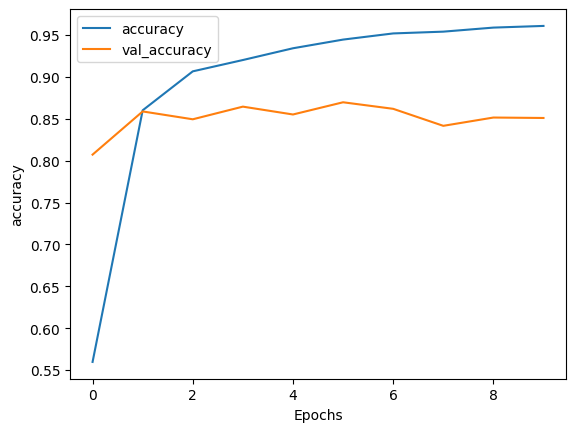

In [26]:
# Importing Matplotlib
import matplotlib.pyplot as plt

# Define a function to plot training history
def plot_graphs(history, metric):
  # Plot the metric and validation metric from the history object

  plt.plot(history.history[metric])             # Plot training metric
  plt.plot(history.history['val_'+metric], '')  # Plot validation metric
  plt.xlabel("Epochs")                          # Set label for X-axis
  plt.ylabel(metric)                            # Set label for Y-axis
  plt.legend([metric, 'val_'+metric])           # Add legend for the plot
  plt.show()                                    # Display the plot

plot_graphs(history, 'accuracy')


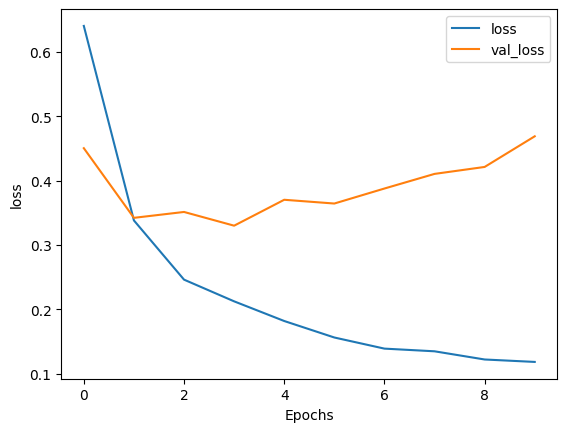

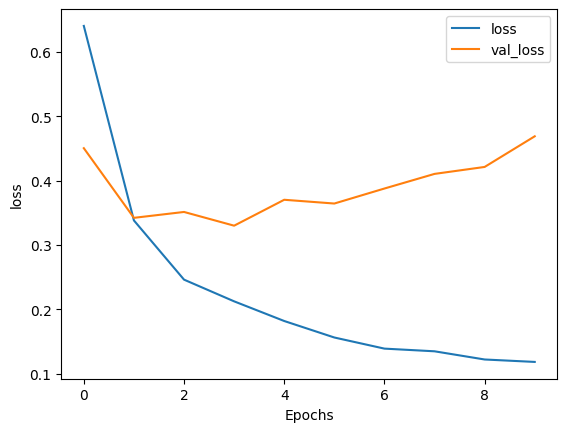

In [27]:
# Printing the loss
plot_graphs(history, 'loss')